In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [36]:
# Basic setup
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load the transactional dataset
df = pd.read_csv("bs140513_032310.csv")

# Preview the data
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (594643, 10)


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [ ]:
# Column info
df.info()

# Count missing values
print("\nMissing values per column:\n", df.isna().sum())


In [ ]:
# Summary stats
df.describe(include='all').T

# Unique customers and transactions
print("Unique customers:", df['customer'].nunique())
print("Total transactions:", len(df))


In [ ]:
# Fraud vs Non-Fraud counts
fraud_counts = df['fraud'].value_counts()
print(fraud_counts)

plt.figure(figsize=(5,4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="Set2")
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Fraud Label")
plt.ylabel("Count")
plt.show()

# Percentage of fraud
fraud_pct = (fraud_counts[1] / len(df)) * 100
print(f"Fraud percentage: {fraud_pct:.3f}%")


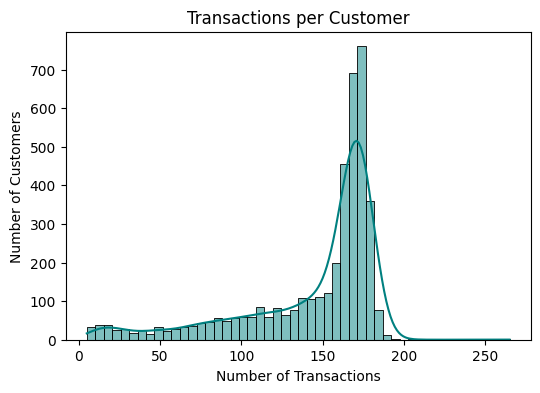

Average transactions per customer: 144.61162451361866


In [37]:
# Transactions per customer
tx_per_customer = df['customer'].value_counts()

plt.figure(figsize=(6,4))
sns.histplot(tx_per_customer, bins=50, color="teal", kde=True)
plt.title("Transactions per Customer")
plt.xlabel("Number of Transactions")
plt.ylabel("Number of Customers")
plt.show()

print("Average transactions per customer:", tx_per_customer.mean())


In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x='fraud', y='amount', data=df, palette="coolwarm")
plt.title("Transaction Amounts by Fraud Status")
plt.xlabel("Fraud")
plt.ylabel("Amount ($)")
plt.yscale('log')   # use log scale for better visibility
plt.show()

# Basic statistics by label
df.groupby('fraud')['amount'].describe()


Time range (steps): 0 to 179


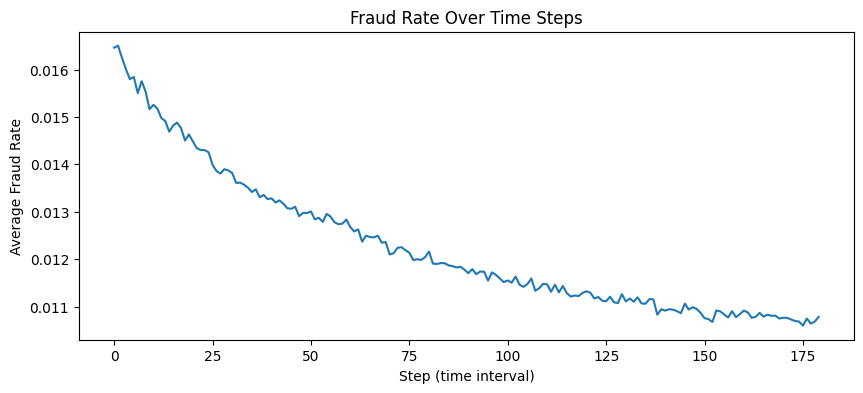

In [38]:
# Check the 'step' column (represents time progression)
print("Time range (steps):", df['step'].min(), "to", df['step'].max())

# Average fraud per time step
fraud_over_time = df.groupby('step')['fraud'].mean()

plt.figure(figsize=(10,4))
fraud_over_time.plot()
plt.title("Fraud Rate Over Time Steps")
plt.xlabel("Step (time interval)")
plt.ylabel("Average Fraud Rate")
plt.show()


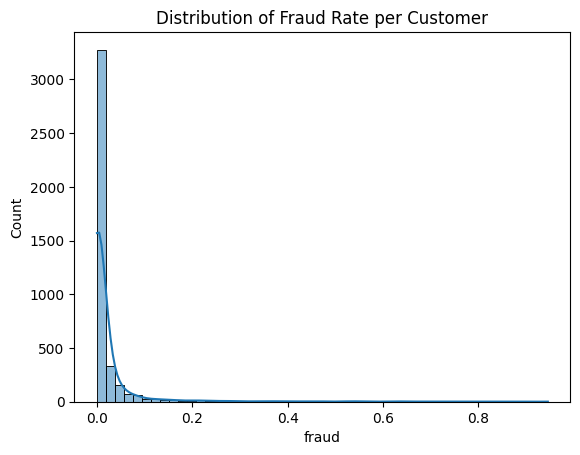

In [39]:
fraud_by_customer = df.groupby('customer')['fraud'].mean()
sns.histplot(fraud_by_customer, bins=50, kde=True)
plt.title("Distribution of Fraud Rate per Customer")
plt.show()


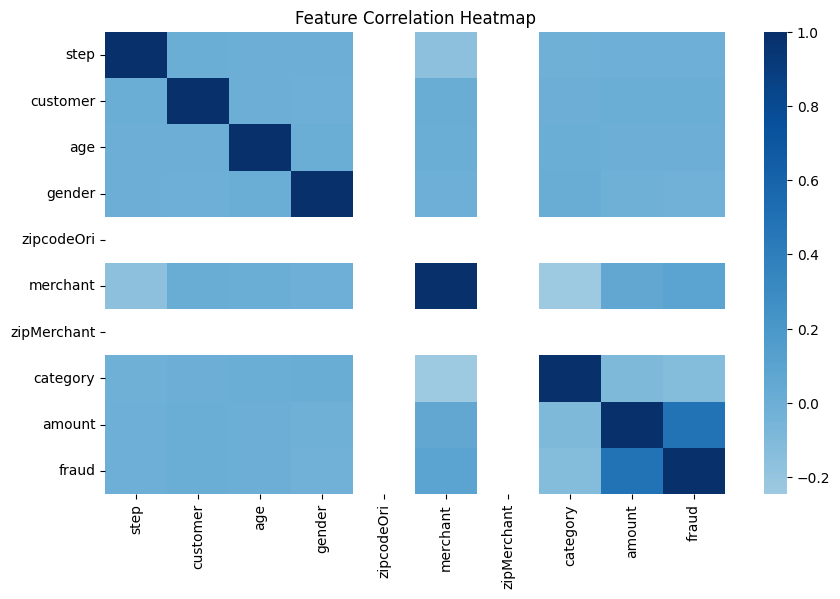

In [40]:
# Encode categorical columns temporarily for correlation
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

plt.figure(figsize=(10,6))
sns.heatmap(df_encoded.corr(), cmap='Blues', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [41]:
# Aggregate historical stats per customer
customer_profile = df.groupby('customer').agg({
    'amount': ['mean', 'std', 'max', 'count'],
    'fraud': 'sum'
})
customer_profile.columns = ['mean_amt', 'std_amt', 'max_amt', 'num_tx', 'fraud_tx']
customer_profile.reset_index(inplace=True)

customer_profile.head()




,customer,mean_amt,std_amt,max_amt,num_tx,fraud_tx
0,'C1000148617',35.091908,36.863536,323.64,131,1
1,'C100045114',90.336239,381.812802,3902.93,109,5
2,'C1000699316',38.154894,41.544414,326.34,94,0
3,'C1001065306',204.754667,306.240251,1260.94,30,11
4,'C1002658784',34.253282,27.820062,197.30,131,0


Using our imbalanced datasets:
1. stratified sampling of the dataset
2. Use methods/models designed for imbalanced datasets
3. Thorough testing

BIAS:
- Check if there is overgeneralization of a one area and that might introduce bias

TODO:
- Check possible sources of bias in data

In [ ]:
# Sort by customer + time
df = df.sort_values(['customer', 'step']).reset_index(drop=True)


In [ ]:
# Group by customer for per-user history
cust_group = df.groupby('customer')

# 1. Previous transaction amount
df['prev_amount'] = cust_group['amount'].shift(1)

# 2. Rolling mean & std of last 3 amounts (excluding current)
df['rolling_mean_3'] = cust_group['amount'].shift(1).rolling(window=3, min_periods=1).mean()
df['rolling_std_3']  = cust_group['amount'].shift(1).rolling(window=3, min_periods=1).std()

# 3. Time gap since last transaction (in steps)
df['time_gap'] = cust_group['step'].diff()

# 4. Merchant change flag (did they switch merchants?)
df['prev_merchant'] = cust_group['merchant'].shift(1)
df['new_merchant'] = (df['merchant'] != df['prev_merchant']).astype(int)

# 5. Amount spike relative to rolling mean
df['amount_spike'] = df['amount'] / (df['rolling_mean_3'] + 1e-3)


In [ ]:
# Handle the NaNs that come from first transactions per customer:
drift_cols = ['prev_amount', 'rolling_mean_3', 'rolling_std_3', 'time_gap', 'amount_spike']
df[drift_cols] = df[drift_cols].fillna(0)

# we don't need prev_merchant as a feature
df = df.drop(columns=['prev_merchant'])


In [ ]:
# Drop non-informative / problematic columns
df = df.drop(columns=['zipcodeOri', 'zipMerchant'], errors='ignore')


In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['age', 'gender', 'merchant', 'category']

for col in cat_cols:
    df[col] = df[col].astype('category')
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


In [ ]:
# Choose a cutoff step for train vs test
cutoff_step = 140  # tweak if you want

train_df = df[df['step'] < cutoff_step].copy()
test_df  = df[df['step'] >= cutoff_step].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


In [ ]:
# Define features and target
target = 'fraud'

drop_cols = ['fraud', 'customer']  # drop label + ID
feature_cols = [c for c in df.columns if c not in drop_cols]

X_train = train_df[feature_cols]
y_train = train_df[target]

X_test = test_df[feature_cols]
y_test = test_df[target]

len(feature_cols), feature_cols[:10]


In [ ]:
# Base-line Model Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# class_weight='balanced' helps with imbalance
log_reg = LogisticRegression(max_iter=500, class_weight='balanced', n_jobs=-1)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))


In [ ]:
# Random Forest - Model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    n_jobs=-1,
    class_weight='balanced',  # again, to deal with imbalance
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))


In [ ]:
# Feature importance (what is the model actually using?)

import pandas as pd

importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances.sort_values(ascending=False).head(15)


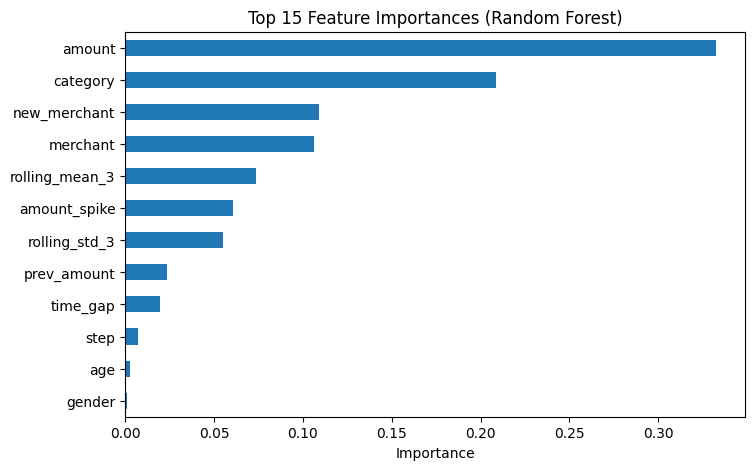

In [35]:
# Feature importance (what is the model actually using?)
top_feats = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
top_feats.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()


/tmp/ipython-input-353524997.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fraud', y='amount_spike', data=df, palette="coolwarm")


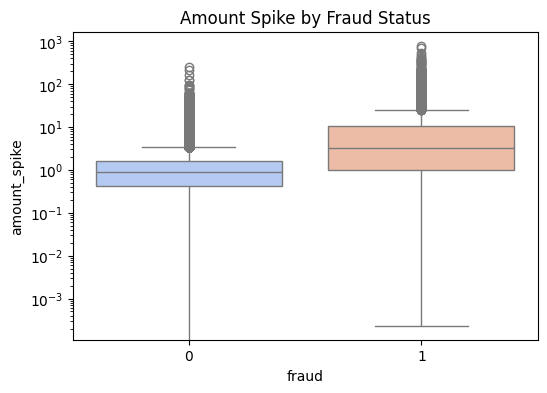

In [34]:
plt.figure(figsize=(6,4))
sns.boxplot(x='fraud', y='amount_spike', data=df, palette="coolwarm")
plt.title("Amount Spike by Fraud Status")
plt.yscale('log')
plt.show()


/tmp/ipython-input-2403982348.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


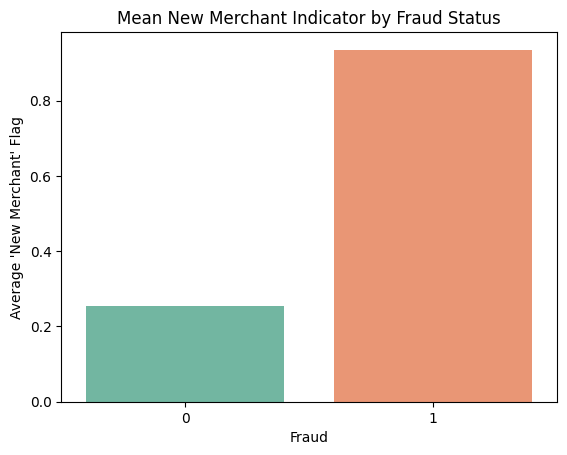

In [33]:
sns.barplot(
    x=df.groupby('fraud')['new_merchant'].mean().index,
    y=df.groupby('fraud')['new_merchant'].mean().values,
    palette='Set2'
)
plt.title("Mean New Merchant Indicator by Fraud Status")
plt.xlabel("Fraud")
plt.ylabel("Average 'New Merchant' Flag")
plt.show()


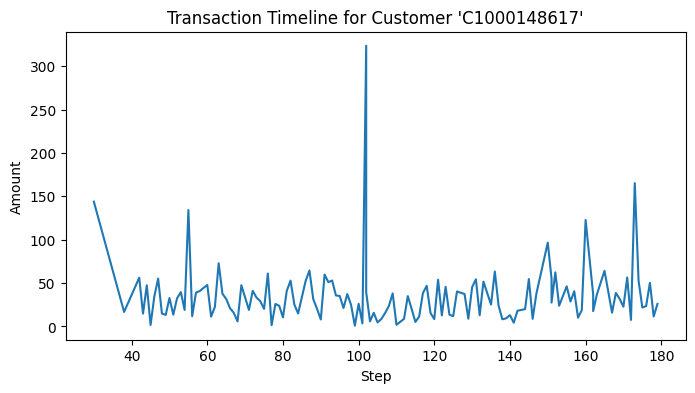

In [32]:
fraud_customer = df[df['fraud']==1]['customer'].iloc[0]
temp = df[df['customer']==fraud_customer]

plt.figure(figsize=(8,4))
plt.plot(temp['step'], temp['amount'])
plt.title(f"Transaction Timeline for Customer {fraud_customer}")
plt.xlabel("Step")
plt.ylabel("Amount")
plt.show()


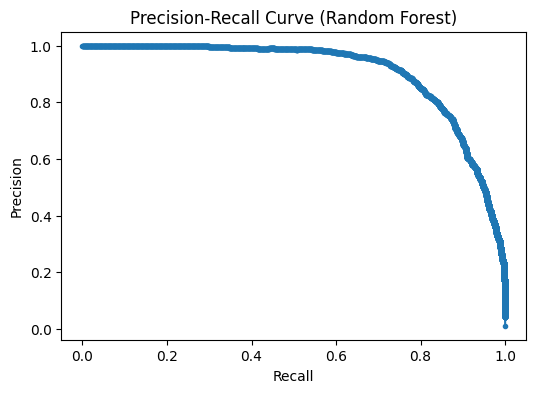

In [31]:
from sklearn.metrics import precision_recall_curve

probs = rf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve (Random Forest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


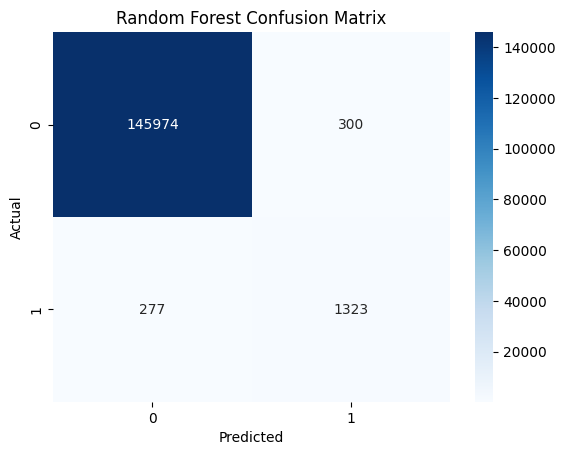

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
